# Objective function for K-Means 

Given some k-means data, plot the objective function. 

We only have three dimensions available for plotting: two for parameters plus one for J itself, so we have to keep it simple. We'll use 1D data and show energy for 2 centroids.

In [1]:
# Import in case of Python2
from __future__ import division, print_function

In [2]:
# Set up inline plotting, and import what we need for 3D plotting and coloumaps
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
# Numpy arrays will make some things easier (and we need them for sklearn)
import numpy as np

In [4]:
# We can test what we're seeing by running the k-means algorithm, implemented in this package
from sklearn.cluster import KMeans

In [5]:
def J(centroids, points):
    """
    Given data x (array of 1D coordinates) and an array of 1D centroids,
    calculate the value of the objective function.
    """
    result = 0
    # For each point, add the square of the distance to the closest centroid
    for point in points:
        # centroids is a numpy array. centroids-point just subtracts the value from each element of the array.
        centroid_distances = np.abs(centroids - point)
        result += np.min(centroid_distances)**2
    return result

In [6]:
def plot_J_1D(points, resolution = 20, jitter = 0):
    """
    Given data points, plot objective function for one centroid.
    Produce two plots: one with objective function, one underneath with data points.
    One centroid forms just one cluster of all points, so we would expect that it
    will have a convex objective function that places it at the mean of all the points.
    """
    x = np.linspace(0, 1, resolution)
    y = [J(c, points) for c in x]
    fig, ax = plt.subplots(2, 1, sharex=True)
    # Plot J
    ax[0].plot(x, y)
    # Plot the original data, optionally with some vertical jitter
    ax[1].scatter(points, 0.5 + np.random.random(len(points))*jitter)

In [7]:
def plot_J_2D(points, resolution=60, start=-0.5, stop=1.5, colour_distortion=4, contour_offset=-1):
    """
    Given data points, plot objective function for two centroids.
    Plot graph from start to stop on both axes, at specified resolution.
    Show contours underneath surface plot.
    Show original data points at edges of contours.
    """
    fig = plt.figure(figsize=(10,8))
    ax = fig.gca(projection='3d')
    
    # Generate the grids of X, Y, Z coordinates
    X = np.linspace(start, stop, resolution)
    Y = np.linspace(start, stop, resolution)
    Xgrid, Ygrid = np.meshgrid(X, Y)
    energy = np.zeros((resolution, resolution))
    
    # Calculate objective function at every point, as a function of centroid parameters
    for (xi, c1) in enumerate(X):
        for (yi, c2) in enumerate(Y):
            energy[xi,yi] = J([c1,c2], points)

    # Choose colours to have more visual discrimination at low energies (optima)
    # Map to 0-1, then map 0-1 to distorted 0-1 with polynomial
    # Power of polynomial gives emphasis of distortion (0 is no distortion)
    # skewed_energy will only be used for colouring
    scaled_energy = (energy - np.min(energy)) / np.max(energy)
    skewed_energy = 1 - (1-scaled_energy)**colour_distortion

    # Plot the objective function surface
    surf = ax.plot_surface(Xgrid, Ygrid, energy, facecolors=cm.jet(1-skewed_energy), rstride=1, cstride=1)  
    
    # Plot contour lines under the surface
    # Put more contour lines near energy minimum, so we can see optima easily
    # We use numpy.logspace, which gives us N lines from min to max distributed along a log curve
    contour_levels = np.logspace(np.log10(np.min(energy)), np.log10(np.max(energy)), 20)
    cset = ax.contour(X, Y, energy, zdir='z', offset=contour_offset,  levels=contour_levels)

    # Plot the original data points below surface along the X and Y axes so we can compare them to contours
    ax.scatter(points, [start]*len(points), [contour_offset]*len(points), c='k', depthshade=False)
    ax.scatter([stop]*len(points), points, [contour_offset]*len(points), c='k', depthshade=False) 
    
    ax.set_xlabel("Centroid 1")
    ax.set_ylabel("Centroid 2")
    ax.set_zlabel("Objective function")

Simple example: two points. If there is one centroid it will be between them. If there are two they should lie on the points.

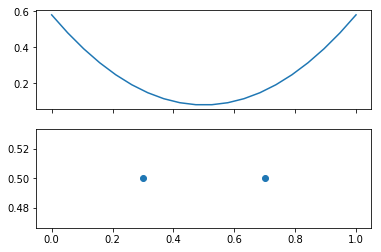

In [8]:
plot_J_1D(np.array([0.3, 0.7]))

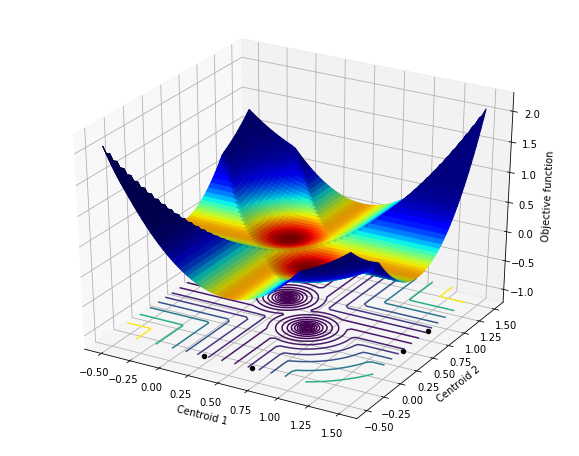

In [9]:
plot_J_2D(np.array([0.3,0.7]), colour_distortion=8, resolution=60)

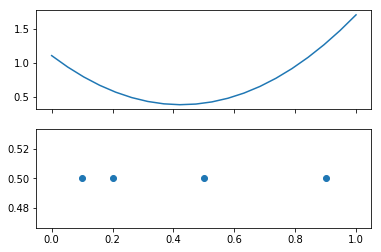

In [10]:
plot_J_1D(np.array([0.1,0.2,0.5,0.9]))

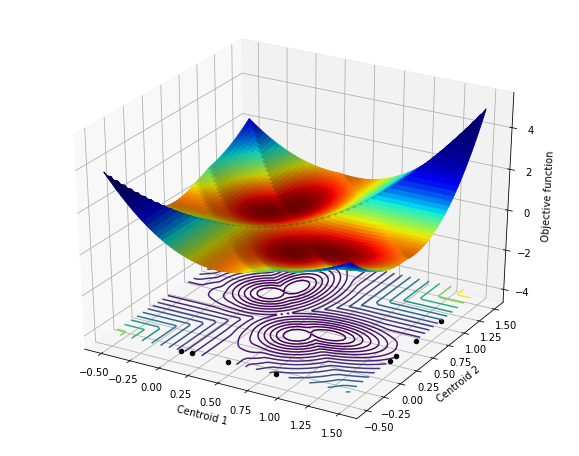

In [11]:
plot_J_2D(np.array([0.1,0.2,0.5,0.9]), colour_distortion=4, resolution=60, contour_offset=-4)


Let's actually do the k-means clustering and see if we get the expected result!

You can see some documentation in Jupyter with `help(KMeans)` once it's imported.

In [12]:
# Create a kmeans instance with k=2
kmeans = KMeans(n_clusters = 2)

In [13]:
# We need our data to be a numpy array or matrix of size n_features (1, for 1D) by n_samples (4, for 4 points)
# This means we need to make sure it's a column rather than a row - here I'm using transpose() for convenience
points = np.array([0.1,0.2,0.5,0.9])
data = np.matrix(points)
data = data.transpose()
data

matrix([[ 0.1],
        [ 0.2],
        [ 0.5],
        [ 0.9]])

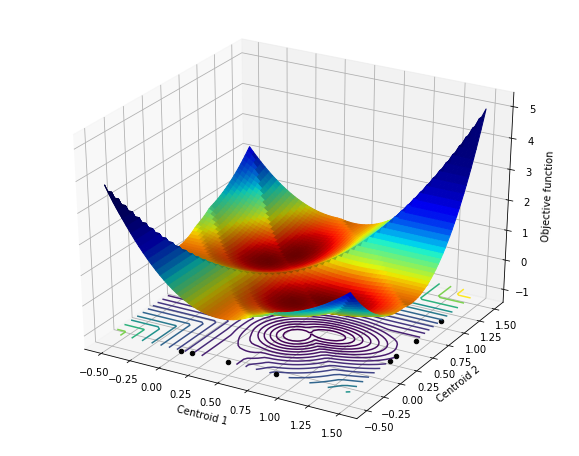

In [14]:
plot_J_2D(points)

In [15]:
# Fit the kmeans parameters to our 1D points by passing it the points
# It will actually rerun several times (n_init times) with different starting centroids, to find a consensus
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [16]:
# What are the resulting cluster centers?
kmeans.cluster_centers_

array([[ 0.7 ],
       [ 0.15]])

In [17]:
# Which points are in which cluster?
kmeans.labels_

array([1, 1, 0, 0], dtype=int32)

In [18]:
# What is the value of the objective function for this solution?
J(kmeans.cluster_centers_, data)

0.08500000000000002

In [19]:
# Try without multiple consensus reruns. Now the result will be more randomised.
kmeans_onceonly = KMeans(n_clusters=2, n_init=1)

In [20]:
kmeans_onceonly.fit(data)
print(kmeans_onceonly.cluster_centers_)
print(kmeans_onceonly.labels_)
print(kmeans_onceonly)
print(J(kmeans.cluster_centers_, data))

[[ 0.26666667]
 [ 0.9       ]]
[0 0 0 1]
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
0.085


In [21]:
kmeans_onceonly.fit(data)
print(kmeans_onceonly.cluster_centers_)
print(kmeans_onceonly.labels_)
print(J(kmeans.cluster_centers_, data))

[[ 0.7 ]
 [ 0.15]]
[1 1 0 0]
0.085


In [22]:
# Here is some data with two equally good solutions for two clusters; 
# rerunning kmeans will give one or the other result 50% of the time
points = np.array([0.1,0.5,0.9])
data = np.matrix(points)
data = data.transpose()
data

matrix([[ 0.1],
        [ 0.5],
        [ 0.9]])

In [ ]:
plot_J_2D(points, colour_distortion=8)

In [ ]:
kmeans.fit(data)
print(kmeans.cluster_centers_)
print(kmeans.labels_)
print(J(kmeans.cluster_centers_, data))

In [ ]:
kmeans.fit(data)
print(kmeans.cluster_centers_)
print(kmeans.labels_)
print(J(kmeans.cluster_centers_, data))